In [1]:
import polars as pl
import pandas as pd
import time
import numpy as np
import requests
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from tqdm import tqdm
pd.set_option('display.max_columns', None)  # Toutes les colonnes
pd.set_option('display.width', None)        # Pas de limite de largeur pour les lignes
pd.set_option('display.max_colwidth', None) # Pas de limite pour la largeur des cellules


In [2]:
import pandas as pd

def change_column_types(df):
    """
    Change les types de plusieurs colonnes dans un DataFrame pandas.

    Parameters:
        df (pd.DataFrame): Le DataFrame pandas.

    Returns:
        pd.DataFrame: Un nouveau DataFrame avec les colonnes modifiées.
    """
    # Dictionnaire des colonnes et leurs types cibles
    dict_type = {
        'id_mutation': 'string',
        'date_mutation': 'datetime64[ns]',
        'numero_disposition': 'string',
        'nature_mutation': 'string',
        'valeur_fonciere': 'float64',
        'adresse_numero': 'string',
        'adresse_suffixe': 'string',
        'adresse_nom_voie': 'string',
        'adresse_code_voie': 'string',
        'code_postal': 'string',
        'code_commune': 'string',
        'nom_commune': 'string',
        'code_departement': 'string',
        'ancien_code_commune': 'string',
        'ancien_nom_commune': 'string',
        'id_parcelle': 'string',
        'ancien_id_parcelle': 'string',
        'numero_volume': 'string',
        'lot1_numero': 'string',
        'lot1_surface_carrez': 'float64',
        'lot2_numero': 'string',
        'lot2_surface_carrez': 'float64',
        'lot3_numero': 'string',
        'lot3_surface_carrez': 'float64',
        'lot4_numero': 'string',
        'lot4_surface_carrez': 'float64',
        'lot5_numero': 'string',
        'lot5_surface_carrez': 'float64',
        'nombre_lots': 'float64',
        'code_type_local': 'string',
        'type_local': 'string',
        'surface_reelle_bati': 'float64',
        'nombre_pieces_principales': 'float64',
        'code_nature_culture': 'string',
        'nature_culture': 'string',
        'code_nature_culture_speciale': 'string',
        'nature_culture_speciale': 'string',
        'surface_terrain': 'float64',
        'longitude': 'float64',
        'latitude': 'float64'
    }

    # Conversion des types de colonnes
    for column_name, column_type in dict_type.items():
        if column_name in df.columns:  # Vérifie que la colonne existe
            try:
                df[column_name] = df[column_name].astype(column_type)
            except Exception as e:
                print(f"Erreur lors de la conversion de la colonne {column_name}: {e}")

    return df

def data_loader(path, departements=[], annees=[]):
    """
    Charge les fichiers CSV d'un répertoire et les concatène dans un DataFrame pandas.

    Parameters:
        path (str): Chemin vers le dossier contenant les données.
        departements (list): Liste des départements à inclure (ex: [1, 75]).
        annees (list): Liste des années à inclure (ex: [2020, 2021]).

    Returns:
        pd.DataFrame: Un DataFrame pandas contenant toutes les données chargées.
    """
    df = pd.DataFrame()

    # Liste des années
    annees_list = os.listdir(path) if not annees else [str(annee) for annee in annees]

    for annee in annees_list:
        cur_year = os.path.join(path, annee)

        # Liste des départements
        if not departements:
            departements_list = os.listdir(cur_year)
        else:
            departements_list = [f"{departement:02}.csv.gz" for departement in departements]

        for departement in departements_list:
            file = os.path.join(cur_year, departement)
            try:
                # Charger les données
                temp_df = pd.read_csv(file, low_memory=False)
                temp_df = change_column_types(temp_df)
                df = pd.concat([df, temp_df], ignore_index=True)
            except Exception as e:
                print(f"Erreur lors du chargement du fichier {file}: {e}")

    return df


In [3]:
path = 'data_dvf'
df = data_loader(path,departements=[75,92,93,94])
df.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2023-1317095,2023-01-03,1,Vente,1825000.00,89.0,<NA>,RUE SAINT-DENIS,8525,75001.0,75101,Paris 1er Arrondissement,75,<NA>,<NA>,75101000AP0050,<NA>,<NA>,1,95.21,26,NaN,27.0,NaN,28.0,NaN,29.0,NaN,7.0,4.0,Local industriel. commercial ou assimilé,165.0,0.0,<NA>,<NA>,<NA>,<NA>,NaN,2.349112,48.862083
1,2023-1317096,2023-01-05,1,Vente,567000.00,51.0,<NA>,RUE DE L ECHIQUIER,3084,75010.0,75110,Paris 10e Arrondissement,75,<NA>,<NA>,75110000AV0075,<NA>,<NA>,7,NaN,8,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,2.0,4.0,Local industriel. commercial ou assimilé,52.0,0.0,<NA>,<NA>,<NA>,<NA>,NaN,2.348283,48.871818
2,2023-1317097,2023-01-04,1,Vente,140000.00,178.0,<NA>,RUE DE COURCELLES,2387,75017.0,75117,Paris 17e Arrondissement,75,<NA>,<NA>,75117000BG0053,<NA>,<NA>,57,18.75,58,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,2.0,2.0,Appartement,18.0,1.0,<NA>,<NA>,<NA>,<NA>,NaN,2.298612,48.884255
3,2023-1317098,2023-01-05,1,Vente,400000.00,12.0,<NA>,RUE TURGOT,9508,75009.0,75109,Paris 9e Arrondissement,75,<NA>,<NA>,75109000BD0036,<NA>,<NA>,831,43.80,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,1.0,2.0,Appartement,43.0,1.0,<NA>,<NA>,<NA>,<NA>,NaN,2.345859,48.880564
4,2023-1317099,2023-01-04,1,Vente,141343.12,63.0,B,RUE DAMREMONT,2534,75018.0,75118,Paris 18e Arrondissement,75,<NA>,<NA>,75118000AK0014,<NA>,<NA>,34,11.40,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>,NaN,1.0,3.0,Dépendance,NaN,0.0,<NA>,<NA>,<NA>,<NA>,NaN,2.334615,48.891525


In [4]:
df = df[
    df["valeur_fonciere"].notnull() &
    df["longitude"].notnull() &
    df["latitude"].notnull() &
    (df["surface_reelle_bati"].notna() | df["surface_terrain"].notna())
]

# Sélectionner les colonnes nécessaires
data = df[[
    'date_mutation', 'type_local', 'surface_reelle_bati', 'nombre_lots',
    'lot1_surface_carrez', 'lot2_surface_carrez', 'lot3_surface_carrez',
    'lot4_surface_carrez', 'lot5_surface_carrez', 'nombre_pieces_principales',
    'nature_culture', 'surface_terrain', 'longitude', 'latitude', 'valeur_fonciere'
]]

# Ajouter les colonnes calculées
data = data.assign(
    sin_month=np.sin(2 * np.pi * pd.to_datetime(data["date_mutation"]).dt.month / 12),
    cos_month=np.cos(2 * np.pi * pd.to_datetime(data["date_mutation"]).dt.month / 12),
    year=pd.to_datetime(data["date_mutation"]).dt.year,
    lot1_surface_carrez=data['lot1_surface_carrez'].fillna(0),
    lot2_surface_carrez=data['lot2_surface_carrez'].fillna(0),
    lot3_surface_carrez=data['lot3_surface_carrez'].fillna(0),
    lot4_surface_carrez=data['lot4_surface_carrez'].fillna(0),
    lot5_surface_carrez=data['lot5_surface_carrez'].fillna(0),
    surface_reelle_bati=data['surface_reelle_bati'].fillna(0),
    surface_terrain=data['surface_terrain'].fillna(0)
)
data.head()

,date_mutation,type_local,surface_reelle_bati,nombre_lots,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year
0,2023-01-03,Local industriel. commercial ou assimilé,165.0,7.0,95.21,0.0,0.0,0.0,0.0,0.0,<NA>,0.0,2.349112,48.862083,1825000.0,0.5,0.866025,2023
1,2023-01-05,Local industriel. commercial ou assimilé,52.0,2.0,0.00,0.0,0.0,0.0,0.0,0.0,<NA>,0.0,2.348283,48.871818,567000.0,0.5,0.866025,2023
2,2023-01-04,Appartement,18.0,2.0,18.75,0.0,0.0,0.0,0.0,1.0,<NA>,0.0,2.298612,48.884255,140000.0,0.5,0.866025,2023
3,2023-01-05,Appartement,43.0,1.0,43.80,0.0,0.0,0.0,0.0,1.0,<NA>,0.0,2.345859,48.880564,400000.0,0.5,0.866025,2023
5,2023-01-03,Appartement,28.0,2.0,0.00,0.0,0.0,0.0,0.0,2.0,<NA>,0.0,2.318419,48.893075,295000.0,0.5,0.866025,2023


In [5]:
# Calculer la somme des surfaces Carrez pour créer la colonne "total_surface_carrez"
data["total_surface_carrez"] = (
    data["lot1_surface_carrez"] +
    data["lot2_surface_carrez"] +
    data["lot3_surface_carrez"] +
    data["lot4_surface_carrez"] +
    data["lot5_surface_carrez"]
)

# Si "total_surface_carrez" est 0, utiliser "surface_reelle_bati" à la place
data["total_surface_carrez"] = np.where(
    data["total_surface_carrez"] == 0,
    data["surface_reelle_bati"],
    data["total_surface_carrez"]
)

# Calculer "valeur_fonciere_m2" en fonction de "surface_reelle_bati" ou "surface_terrain"
data["valeur_fonciere_m2"] = np.where(
    data["surface_reelle_bati"] != 0,
    (data["valeur_fonciere"] / data["surface_reelle_bati"]).round(0),
    (data["valeur_fonciere"] / data["surface_terrain"]).round(0)
)
data = data[data['valeur_fonciere_m2'] != 0]
data["valeur_fonciere_m2_log"]= data["valeur_fonciere_m2"].apply(lambda x: np.log10(x))
data.head()

,date_mutation,type_local,surface_reelle_bati,nombre_lots,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year,total_surface_carrez,valeur_fonciere_m2,valeur_fonciere_m2_log
0,2023-01-03,Local industriel. commercial ou assimilé,165.0,7.0,95.21,0.0,0.0,0.0,0.0,0.0,<NA>,0.0,2.349112,48.862083,1825000.0,0.5,0.866025,2023,95.21,11061.0,4.043794
1,2023-01-05,Local industriel. commercial ou assimilé,52.0,2.0,0.00,0.0,0.0,0.0,0.0,0.0,<NA>,0.0,2.348283,48.871818,567000.0,0.5,0.866025,2023,52.00,10904.0,4.037586
2,2023-01-04,Appartement,18.0,2.0,18.75,0.0,0.0,0.0,0.0,1.0,<NA>,0.0,2.298612,48.884255,140000.0,0.5,0.866025,2023,18.75,7778.0,3.890868
3,2023-01-05,Appartement,43.0,1.0,43.80,0.0,0.0,0.0,0.0,1.0,<NA>,0.0,2.345859,48.880564,400000.0,0.5,0.866025,2023,43.80,9302.0,3.968576
5,2023-01-03,Appartement,28.0,2.0,0.00,0.0,0.0,0.0,0.0,2.0,<NA>,0.0,2.318419,48.893075,295000.0,0.5,0.866025,2023,28.00,10536.0,4.022676


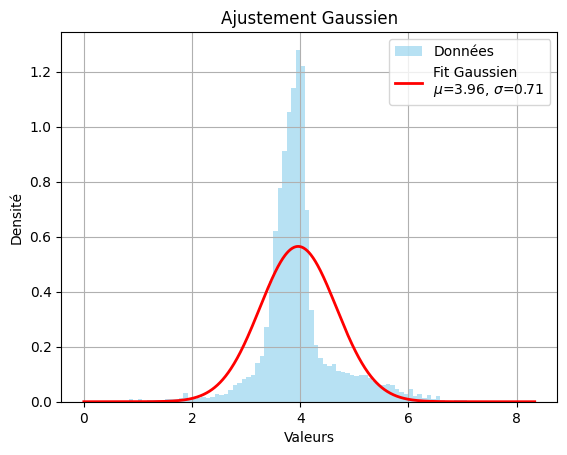

Moyenne (mu): 3.96
Écart-type (sigma): 0.71


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
x = data['valeur_fonciere_m2_log'].to_numpy()
# Calcul de la moyenne et de l'écart-type
mu, sigma = norm.fit(x)  # Ajuste une gaussienne et retourne la moyenne et l'écart-type

# Tracer l'histogramme des données
plt.hist(x, bins=100, density=True, alpha=0.6, color='skyblue', label="Données")

# Créer une courbe gaussienne avec les paramètres ajustés
x = np.linspace(min(x), max(x), 1000)
pdf = norm.pdf(x, mu, sigma)  # Fonction de densité de probabilité
plt.plot(x, pdf, color='red', linewidth=2, label=f"Fit Gaussien\n$\mu$={mu:.2f}, $\sigma$={sigma:.2f}")

# Ajouter des labels et une légende
plt.xlabel("Valeurs")
plt.ylabel("Densité")
plt.title("Ajustement Gaussien")
plt.legend()
plt.grid()
plt.show()

print(f"Moyenne (mu): {mu:.2f}")
print(f"Écart-type (sigma): {sigma:.2f}")


In [7]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.3,bootstrap=True, random_state=42)
data['anomalie'] = model.fit_predict(data[['valeur_fonciere','total_surface_carrez']])
df_cleaned = data[data['anomalie'] == 1]
print(f"{data.size-df_cleaned.size} lignes enlevées, taille finale : {df_cleaned.size}")


4508504 lignes enlevées, taille finale : 10525416


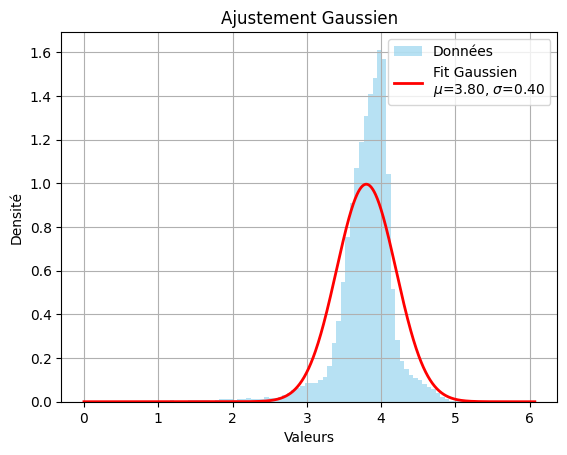

Moyenne (mu): 3.80
Écart-type (sigma): 0.40


In [8]:
x = df_cleaned['valeur_fonciere_m2_log'].to_numpy()
# Calcul de la moyenne et de l'écart-type
mu, sigma = norm.fit(x)  # Ajuste une gaussienne et retourne la moyenne et l'écart-type

# Tracer l'histogramme des données
plt.hist(x, bins=100, density=True, alpha=0.6, color='skyblue', label="Données")

# Créer une courbe gaussienne avec les paramètres ajustés
x = np.linspace(min(x), max(x), 1000)
pdf = norm.pdf(x, mu, sigma)  # Fonction de densité de probabilité
plt.plot(x, pdf, color='red', linewidth=2, label=f"Fit Gaussien\n$\mu$={mu:.2f}, $\sigma$={sigma:.2f}")

# Ajouter des labels et une légende
plt.xlabel("Valeurs")
plt.ylabel("Densité")
plt.title("Ajustement Gaussien")
plt.legend()
plt.grid()
plt.show()

print(f"Moyenne (mu): {mu:.2f}")
print(f"Écart-type (sigma): {sigma:.2f}")

In [9]:
from scipy.spatial import cKDTree

def idw_predict_kdtree(data, lon_col="longitude", lat_col="latitude", value_col="valeur_fonciere_m2", power=2, k=10):
    """
    Prédit les valeurs d'un DataFrame en utilisant l'Interpolation Inverse Distance Weighting (IDW) optimisée avec un KD-Tree.

    Paramètres :
        data : pd.DataFrame, DataFrame contenant les colonnes latitude, longitude et valeur foncière.
        lat_col : str, nom de la colonne latitude.
        lon_col : str, nom de la colonne longitude.
        value_col : str, nom de la colonne des valeurs à prédire.
        power : float, puissance de pondération (typiquement 2).
        k : int, nombre de voisins à considérer pour chaque point.

    Retourne :
        pd.Series, colonne des valeurs prédites pour chaque point.
    """
    # Extraire les coordonnées et les valeurs
    coordinates = data[[lat_col, lon_col]].to_numpy()
    values = data[value_col].to_numpy()

    # Construire le KD-Tree
    tree = cKDTree(coordinates)

    predicted_values = []
    for i, point in enumerate(coordinates):
        # Trouver les k voisins les plus proches
        distances, indices = tree.query(point, k=k + 1)  # k+1 car le point lui-même est inclus

        # Exclure le point lui-même (distance 0)
        mask = distances > 0
        distances = distances[mask]
        indices = indices[mask]

        # Si aucun voisin valide n'est trouvé
        if len(distances) == 0:
            predicted_values.append(values[i])  # Retourner la valeur du point lui-même
            continue

        # Calculer les poids en fonction des distances
        weights = 1 / (distances ** power)

        # Calculer la valeur interpolée
        interpolated_value = np.round(np.sum(weights * values[indices]) / np.sum(weights), -1)
        predicted_values.append(interpolated_value)

    # Retourner les résultats sous forme de pd.Series
    return pd.Series(predicted_values, name=f"{value_col}_predite_par_le_quartier")


In [10]:
# Appliquer la fonction idw_predict_kdtree et ajouter la colonne prédite au DataFrame pandas
value_col = "valeur_fonciere_m2"
df_cleaned[f"{value_col}_predite_par_le_quartier"] = idw_predict_kdtree(df_cleaned, lon_col="longitude", lat_col="latitude", value_col= value_col, k=100)
df_cleaned = df_cleaned[~df_cleaned['valeur_fonciere_m2_predite_par_le_quartier'].isna()]
df_cleaned = df_cleaned[np.isfinite(df_cleaned['valeur_fonciere_m2_predite_par_le_quartier'])]

# Afficher les premières lignes du DataFrame
df_cleaned.head()


/tmp/ipykernel_82129/3789363173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[f"{value_col}_predite_par_le_quartier"] = idw_predict_kdtree(df_cleaned, lon_col="longitude", lat_col="latitude", value_col= value_col, k=100)


,date_mutation,type_local,surface_reelle_bati,nombre_lots,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year,total_surface_carrez,valeur_fonciere_m2,valeur_fonciere_m2_log,anomalie,valeur_fonciere_m2_predite_par_le_quartier
1,2023-01-05,Local industriel. commercial ou assimilé,52.0,2.0,0.00,0.0,0.0,0.0,0.0,0.0,<NA>,0.0,2.348283,48.871818,567000.0,0.5,0.866025,2023,52.00,10904.0,4.037586,1,12900.0
2,2023-01-04,Appartement,18.0,2.0,18.75,0.0,0.0,0.0,0.0,1.0,<NA>,0.0,2.298612,48.884255,140000.0,0.5,0.866025,2023,18.75,7778.0,3.890868,1,12490.0
3,2023-01-05,Appartement,43.0,1.0,43.80,0.0,0.0,0.0,0.0,1.0,<NA>,0.0,2.345859,48.880564,400000.0,0.5,0.866025,2023,43.80,9302.0,3.968576,1,9270.0
5,2023-01-03,Appartement,28.0,2.0,0.00,0.0,0.0,0.0,0.0,2.0,<NA>,0.0,2.318419,48.893075,295000.0,0.5,0.866025,2023,28.00,10536.0,4.022676,1,7340.0
7,2023-01-03,Appartement,36.0,2.0,36.11,0.0,0.0,0.0,0.0,2.0,<NA>,0.0,2.349162,48.891187,300400.0,0.5,0.866025,2023,36.11,8344.0,3.921374,1,11730.0


<Axes: xlabel='valeur_fonciere_m2_predite_par_le_quartier', ylabel='Count'>

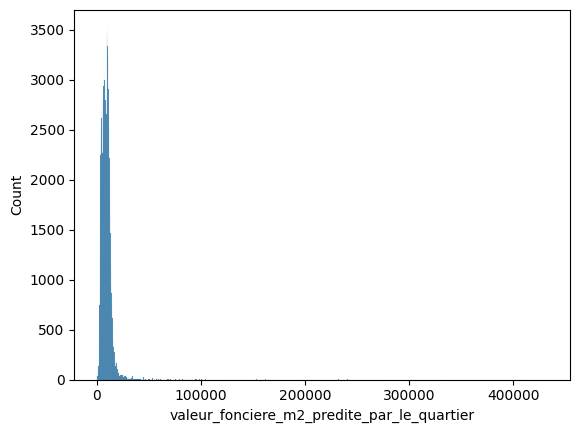

In [11]:
import seaborn as sns

sns.histplot(data=df_cleaned,x="valeur_fonciere_m2_predite_par_le_quartier")

In [12]:
df_cleaned.describe()

,date_mutation,surface_reelle_bati,nombre_lots,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,nombre_pieces_principales,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year,total_surface_carrez,valeur_fonciere_m2,valeur_fonciere_m2_log,anomalie,valeur_fonciere_m2_predite_par_le_quartier
count,166000,166000.000000,166000.000000,166000.000000,166000.000000,166000.000000,166000.000000,166000.000000,163434.000000,166000.000000,166000.000000,166000.000000,1.660000e+05,1.660000e+05,1.660000e+05,166000.000000,166000.000000,166000.000000,166000.000000,166000.0,166000.000000
mean,2022-12-26 16:26:19.315662592,47.319367,1.357398,21.194963,6.532783,0.350806,0.064649,0.017958,2.227131,101.184783,2.360309,48.865000,4.094871e+05,8.619890e-03,-5.192100e-02,2022.492090,47.358823,9075.827681,3.819396,1.0,8896.685819
min,2022-01-03 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.147277,48.691041,1.000000e+01,-1.000000e+00,-1.000000e+00,2022.000000,0.000000,1.000000,0.000000,1.0,8.000000
25%,2022-06-30 00:00:00,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.292692,48.838022,2.200000e+05,-5.000000e-01,-8.660254e-01,2022.000000,28.997500,4759.000000,3.677516,1.0,5790.000000
50%,2022-12-23 00:00:00,45.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.348167,48.868527,3.371550e+05,1.224647e-16,-1.836970e-16,2022.000000,46.000000,7679.000000,3.885305,1.0,8500.000000
75%,2023-06-22 00:00:00,65.000000,2.000000,41.050000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,2.409023,48.894019,5.215000e+05,5.000000e-01,5.000000e-01,2023.000000,65.642500,10665.000000,4.027961,1.0,10990.000000
max,2023-12-31 00:00:00,4763.000000,20.000000,107.910000,107.910000,107.100000,102.920000,104.450000,50.000000,49999.000000,2.596639,48.985260,2.743970e+06,1.000000e+00,1.000000e+00,2023.000000,108.000000,660000.000000,5.819544,1.0,433330.000000
std,NaN,28.487371,0.877795,27.945676,18.827236,4.585377,1.967888,1.073772,1.269351,884.070792,0.091778,0.045369,2.819250e+05,7.020287e-01,7.102053e-01,0.499939,24.843310,10655.826056,0.400459,0.0,5920.107059


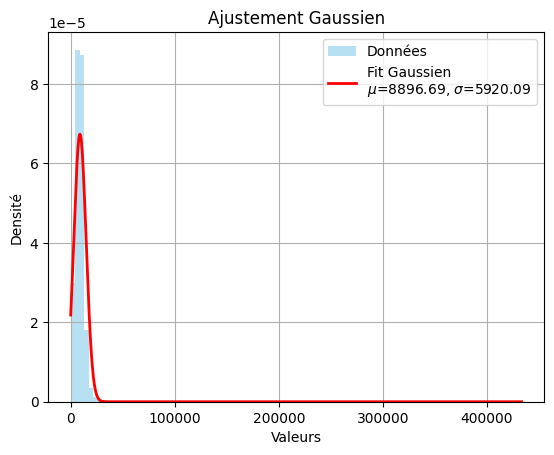

Moyenne (mu): 8896.69
Écart-type (sigma): 5920.09


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
x = df_cleaned['valeur_fonciere_m2_predite_par_le_quartier'].to_numpy()
# Calcul de la moyenne et de l'écart-type
mu, sigma = norm.fit(x)  # Ajuste une gaussienne et retourne la moyenne et l'écart-type

# Tracer l'histogramme des données
plt.hist(x, bins=100, density=True, alpha=0.6, color='skyblue', label="Données")

# Créer une courbe gaussienne avec les paramètres ajustés
x = np.linspace(min(x), max(x), 1000)
pdf = norm.pdf(x, mu, sigma)  # Fonction de densité de probabilité
plt.plot(x, pdf, color='red', linewidth=2, label=f"Fit Gaussien\n$\mu$={mu:.2f}, $\sigma$={sigma:.2f}")

# Ajouter des labels et une légende
plt.xlabel("Valeurs")
plt.ylabel("Densité")
plt.title("Ajustement Gaussien")
plt.legend()
plt.grid()
plt.show()

print(f"Moyenne (mu): {mu:.2f}")
print(f"Écart-type (sigma): {sigma:.2f}")


In [14]:
donnees = df_cleaned[(df_cleaned['valeur_fonciere_m2_predite_par_le_quartier']<mu+2*sigma) & (df_cleaned['valeur_fonciere_m2_predite_par_le_quartier']> mu-2*sigma)]

In [15]:
df_popd = pd.read_csv('data_pop_density/dataframe_densite&amenities_radius=500.csv')
df_popd.drop(columns='Unnamed: 0',inplace=True)
df_popd

,lat,lon,densite,transport_pois,education_pois,health_pois,food_pois,shopping_pois,park_pois,entertainment_pois,cultural_pois
0,41.337082,9.252916,13.983237,0,0,0,0,0,0,0,0
1,41.337082,9.261250,12.697619,0,0,0,0,0,0,0,0
2,41.345417,9.244583,8.738704,0,0,0,0,0,0,0,0
3,41.345417,9.252916,16.828238,0,0,0,0,0,0,0,0
4,41.345417,9.261250,14.136576,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
932759,51.078750,2.544583,237.373210,0,0,0,0,0,0,0,0
932760,51.078750,2.552917,435.237270,0,0,0,2,0,0,0,0
932761,51.087082,2.527917,236.395450,0,0,0,0,0,0,0,0
932762,51.087082,2.536250,191.215910,0,0,0,0,0,0,0,0


Shape: 3.97, Scale: 2243.30


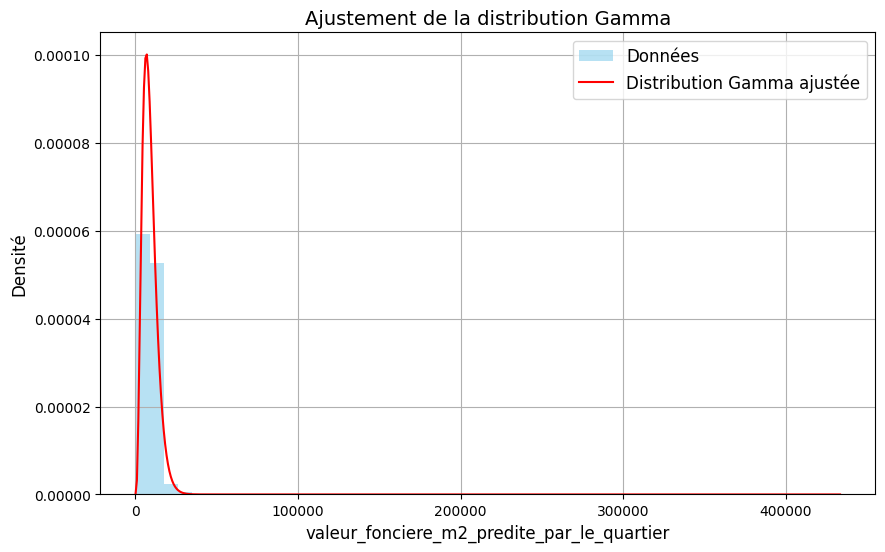

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Exemple : données positives
data_gamma = df_cleaned['valeur_fonciere_m2_predite_par_le_quartier']

# Ajuster les paramètres de la distribution gamma
shape, loc, scale = gamma.fit(data_gamma, floc=0)  # floc=0 force le paramètre "loc" à zéro

print(f"Shape: {shape:.2f}, Scale: {scale:.2f}")

# Générer des valeurs pour tracer la densité de probabilité
x = np.linspace(min(data_gamma), max(data_gamma), 500)
pdf = gamma.pdf(x, shape, loc=loc, scale=scale)

# Tracer les données et la distribution ajustée
plt.figure(figsize=(10, 6))

# Histogramme des données
plt.hist(data_gamma, bins=50, density=True, alpha=0.6, color="skyblue", label="Données")

# Courbe de la densité ajustée
plt.plot(x, pdf, "red", label="Distribution Gamma ajustée")

# Ajouter des légendes et des titres
plt.title("Ajustement de la distribution Gamma", fontsize=14)
plt.xlabel("valeur_fonciere_m2_predite_par_le_quartier", fontsize=12)
plt.ylabel("Densité", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree

def find_weighted_poi_counts(donnees, df_grid, poi_columns):
    """
    Calcule une moyenne pondérée des colonnes POIs des quatre voisins les plus proches
    pour chaque point du DataFrame `donnees` en utilisant un arbre k-d (cKDTree).

    Parameters:
    - donnees (pandas.DataFrame): DataFrame contenant les coordonnées des points pour lesquels
      les POIs pondérés doivent être calculés. Il doit contenir les colonnes 'latitude' et 'longitude'.
    - df_grid (pandas.DataFrame): DataFrame contenant le quadrillage avec coordonnées et colonnes POIs.
      Il doit contenir les colonnes 'lat', 'lon' et les colonnes spécifiées dans `poi_columns`.
    - poi_columns (list): Liste des noms des colonnes POIs dans `df_grid` à inclure dans les calculs.

    Returns:
    - pandas.DataFrame: DataFrame enrichi avec les colonnes pondérées des POIs.
    """
    # Extraire les coordonnées des deux ensembles
    latitudes_data = donnees['latitude'].values
    longitudes_data = donnees['longitude'].values

    latitudes_grid = df_grid['lat'].values
    longitudes_grid = df_grid['lon'].values

    # Créer un cKDTree pour une recherche rapide
    tree = cKDTree(np.vstack((longitudes_grid, latitudes_grid)).T)

    # Chercher les 4 voisins les plus proches pour chaque point
    distances, indices = tree.query(np.vstack((longitudes_data, latitudes_data)).T, k=4)

    # Calculer les poids en fonction de l'inverse des distances
    weights = 1 / np.where(distances == 0, 1e-10, distances)  # Évite la division par zéro
    normalized_weights = weights / weights.sum(axis=1, keepdims=True)

    # Calculer les moyennes pondérées pour chaque colonne POI
    for col in poi_columns:
        poi_values = df_grid[col].values
        # Récupérer les valeurs des voisins pour cette colonne
        neighbors_poi = poi_values[indices]
        # Calculer la moyenne pondérée
        donnees[f"{col}_weighted"] = np.floor((neighbors_poi * normalized_weights).sum(axis=1))

    return donnees
